# Laboratorio 8

Diego Andrés Morales Aquino - 21762\
Pablo Andrés Zamora Vásquez - 21780

In [5]:
#%pip install ydata-profiling

# Parte 1

In [6]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [7]:
df = pd.read_csv('houses_to_rent_v2.csv')

In [8]:
df.head()

city  area  rooms  bathroom  parking spaces floor     animal  \
0     São Paulo    70      2         1               1     7      acept   
1     São Paulo   320      4         4               0    20      acept   
2  Porto Alegre    80      1         1               1     6      acept   
3  Porto Alegre    51      2         1               0     2      acept   
4     São Paulo    25      1         1               0     1  not acept   

       furniture  hoa (R$)  rent amount (R$)  property tax (R$)  \
0      furnished      2065              3300                211   
1  not furnished      1200              4960               1750   
2  not furnished      1000              2800                  0   
3  not furnished       270              1112                 22   
4  not furnished         0               800                 25   

   fire insurance (R$)  total (R$)  
0                   42        5618  
1                   63        7973  
2                   41        3841  
3                   17        1421  
4                   11         836

## Análisis exploratorio

### Tipos de variables

In [9]:
df.dtypes

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

El tipo de la variable "floor" debe ser corregido a un valor numérico para mantener la información referente al órden de los pisos y la altura.

### Número de columnas y filas

In [10]:
shape = df.shape
print(f'Filas: {shape[0]}\nColumnas: {shape[1]}')

Filas: 10692
Columnas: 13


In [11]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

El conjunto de datos cuenta con un total de 13 variables y 10692 observaciones (filas). La variable "floor" cuenta con 2461 datos faltantes.

In [12]:
# Corregir tipo de variable "floor"
df['floor'] = df['floor'].replace('-', np.nan).astype('Int64')

### Distribución de variables

In [13]:
def generate_histograms():
  # Separar columnas numéricas y categóricas
  numeric_columns = df.select_dtypes(include=['number']).columns
  categorical_columns = df.select_dtypes(include=['object']).columns

  # Crear histogramas para las variables numéricas
  df.hist(bins=15, layout=(4, 3), figsize=(15, 10), color='blue', edgecolor='black')
  plt.suptitle("Histogramas de las Variables Numéricas")
  plt.show()

generate_histograms()

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_33384\3766500670.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



En general, la mayoría de las variables numéricas presentan distribuciones asimétricas hacia la derecha, lo que significa que hay pocos valores altos y la mayoría de los datos están concentrados en los valores más bajos. Por ejemplo, las áreas de las propiedades suelen ser menores a 10,000 metros cuadrados, y los impuestos de la Asociación de Dueños (HOA), al igual que el impuesto sobre bienes inmuebles y el seguro contra incendios, tienen la mayor concentración en valores bajos, con algunos pocos casos extremos de valores mucho más altos. Las mensualidades de renta y el total de la renta mensual también siguen esta tendencia, donde la mayoría de los valores son relativamente bajos y solo unas pocas propiedades tienen rentas significativamente más altas.

Por otro lado, las variable "area" y "hoa (R$)", "property tax" y "total", aparentan tener todos sus valores en cero; sin embargo, esto se debe a la escala que se maneja, lo cual advierte de la existencia de puntos atípicos muy lejanos al resto de datos.

In [14]:
# Mostrar diagramas de frecuencia para variables categóricas

categorical_columns = df.select_dtypes(include=['object']).columns

# Número de columnas y filas para los subplots
num_plots = len(categorical_columns)
cols = 2
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Crear los diagramas de frecuencia
for i, column in enumerate(categorical_columns):
    sns.countplot(x=df[column], palette='viridis', ax=axes[i])
    axes[i].set_title(f'Diagrama de Frecuencia de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_33384\208478448.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Con respecto a la frecuencia de las variables categóricas se observan los siguientes resultados:

* Sao Paulo tiene la mayor frecuencia, con cerca de 6000 propiedades, seguida por Rio de Janeiro con alrededor de 1500. Porto Alegre, Campinas y Belo Horizonte tienen frecuencias similares, entre 1000 y 1500 propiedades cada una.

* Hay una clara división, con aproximadamente 8000 propiedades que aceptan mascotas y unas 2500 que no las permiten.
* La mayoría de las propiedades (alrededor de 8000) no están amuebladas, mientras que cerca de 2500 sí lo están.

### Diagrama de caja y bigotes de variables numéricas

In [15]:
# Diagramas de Caja y Bigotes (Box and Whisker Plots)
def generate_boxplot():
  df.plot(kind='box', subplots=True, layout=(6, 2), figsize=(15, 20), color='red')
  plt.suptitle("Diagramas de Caja y Bigotes")
  plt.show()

generate_boxplot()

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_33384\2602217334.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [16]:
# Obtener el número de puntos atípicos
numeric_columns = df.select_dtypes(include=['number'])

outliers_count = {}

for column in numeric_columns:
    Q1 = df[column].quantile(0.25)  # Primer cuartil
    Q3 = df[column].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir los límites para detectar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    percent = (len(outliers) / len(df)) * 100
    outliers_count[column] = f"{len(outliers)}, {round(percent, 2)} del total."

print("Cantidad de datos atípicos: ")
outliers_count

Cantidad de datos atípicos: 


{'area': '672, 6.29 del total.',
 'rooms': '408, 3.82 del total.',
 'bathroom': '103, 0.96 del total.',
 'parking spaces': '322, 3.01 del total.',
 'floor': '224, 2.1 del total.',
 'hoa (R$)': '717, 6.71 del total.',
 'rent amount (R$)': '715, 6.69 del total.',
 'property tax (R$)': '1081, 10.11 del total.',
 'fire insurance (R$)': '809, 7.57 del total.',
 'total (R$)': '706, 6.6 del total.'}

En casi todas las variables se observan varios valores atípicos que se encuentran mucho más allá de los rangos intercuartiles. Estos outliers representan propiedades con características inusuales, como áreas extremadamente grandes o costos considerablemente más altos. Dado que la mediana se encuentra más cerca a los valores mínimos, se puede observar que los valores atípicos representan en todo los casos cantidades grandes, evidenciando un sesgo hacia los valores bajos.

Dado que los puntos atípicos en la mayoría de las variables representan más del 5% de los datos, se pocederá a eliminar únicamente los puntos más lejanos, dado que eliminarlos todos pordría representar una pérdida significativa de información.

### Matriz de correlación

In [17]:
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_33384\2394096421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


El mapa de calor muestra las correlaciones entre las variables numéricas del conjunto de datos. Se observa una fuerte correlación positiva entre el valor total de la propiedad (total) y el HOA (impuesto de la Asociación de Dueños) con un coeficiente de 0.96, lo cual indica que mientras mayor es el total de la renta mensual mayor será el cobro de dicho impuesto. Por otro lado, también existe una correlación fuerte positiva (con un coeficiente de correlación de 0.99) entre las variables rent amount y fire insurance, lo cual establece que mientras mayor sea la mensualidad, también aumenta el costo del seguro contra incendios. Además, el número de baños ,los espacios de parqueo y el número de habitaciones tienen correlaciones moderadas entre sí, lo cual sugiere que las propiedades con más habitaciones y por lo tanto diseñadas para el uso de un mayor número de personas, suelen tener mayor disponibilidad de otros servicios como el número de baños y espacios para parqueo. Por otro lado, el area (tamaño en metros cuadrados) no muestra una fuerte correlación con ninguna variable, lo que implica que el tamaño de la propiedad no afecta significativamente las otras variables financieras o de características del inmueble.

## Limpieza de datos

### Eliminar puntos atípicos más lejanos

In [18]:
start_rows = df.shape[0]

# Variable area
df = df.drop(df[df['area'] > 1500].index)

# Variable piso
df = df.drop(df[df['floor'] > 100].index)

# hoa
df = df.drop(df[df['hoa (R$)'] > 12500].index)

#property tax
df = df.drop(df[df['property tax (R$)'] > 15000].index)

# fire insurance
df = df.drop(df[df['fire insurance (R$)'] > 400].index)

#total
df = df.drop(df[df['total (R$)'] > 50000].index)


print("Se eliminó el", (start_rows - df.shape[0]) / start_rows * 100, "% de los datos.")

Se eliminó el 0.205761316872428 % de los datos.


Una vez eliminados los puntos atípicos más lejanos, la distribución de las variables se observa así:

In [19]:
generate_histograms()

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_33384\3766500670.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Manejo de valores faltantes

In [20]:
# Reemplazar valores faltantes de "floor" por la moda
mode_floor = df['floor'].mode()[0]
df['floor'] = df['floor'].fillna(mode_floor)

In [21]:
print(f"Número de datos faltantes: ", df.isna().sum().sum())

Número de datos faltantes:  0


## Preparación de datos

### Codificar variables categóricas

Convertir animal y furniture en variables binarias

In [22]:
df['animal'] = df['animal'].apply(lambda x: 1 if x == 'acept' else 0)
df['furniture'] = df['furniture'].apply(lambda x: 1 if x == 'furnished' else 0)

In [23]:
df.head()


city  area  rooms  bathroom  parking spaces  floor  animal  \
0     São Paulo    70      2         1               1      7       1   
1     São Paulo   320      4         4               0     20       1   
2  Porto Alegre    80      1         1               1      6       1   
3  Porto Alegre    51      2         1               0      2       1   
4     São Paulo    25      1         1               0      1       0   

   furniture  hoa (R$)  rent amount (R$)  property tax (R$)  \
0          1      2065              3300                211   
1          0      1200              4960               1750   
2          0      1000              2800                  0   
3          0       270              1112                 22   
4          0         0               800                 25   

   fire insurance (R$)  total (R$)  
0                   42        5618  
1                   63        7973  
2                   41        3841  
3                   17        1421  
4                   11         836

In [24]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

y = y.reshape(len(y),1)

Codificar países

In [25]:
encoder_city = ColumnTransformer(transformers=[
    ('encoder_city', OneHotEncoder(), [0])
    ], remainder='passthrough', sparse_threshold=0)
X = np.array(encoder_city.fit_transform(X))

### Normalizar datos
Para los modelos lineal, decision tree y random forest no es necesario normalizar.

## Dividir en entranamiento y prueba

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

## Implementación de algoritmos de regresión

### Regresión lineal

In [27]:
regresor_lin = LinearRegression()
regresor_lin.fit(X_train, y_train)

LinearRegression()

In [28]:
# Validación cruzada
cal = cross_val_score(regresor_lin, X_train, y_train,
                         scoring = 'r2', cv = 10)
print(f"R2: {abs(cal.mean())}")

R2: 0.9999987756307289


In [29]:
# Evaluación con datos de prueba
y_pred = regresor_lin.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")

R2: 0.9999965366003123


In [30]:
print("Coeficientes del modelo lineal:")
print(regresor_lin.coef_)

Coeficientes del modelo lineal:
[[-7.44441670e-02 -4.74669665e-02 -1.90054822e-04 -1.34815908e-02
   1.35582779e-01 -8.56438172e-04  2.14201486e-02  3.63362414e-02
   5.01499850e-02 -8.55558323e-03  5.83311672e-02 -1.41195086e-01
   9.99919088e-01  1.00013449e+00  9.99998319e-01  9.93386682e-01]]


### Árbol de decisión

In [31]:
regresor_tree = DecisionTreeRegressor(random_state = 0)
regresor_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [32]:
# Validación cruzada
cal = cross_val_score(regresor_tree, X_train, y_train.ravel(),
                         scoring = 'r2', cv = 10)
print(f"R2: {abs(cal.mean())}")

R2: 0.9900454425913155


In [33]:
# Evaluación con datos de prueba
y_pred = regresor_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")

R2: 0.9916719699427986


### Random Forest

In [34]:
regresor_ranf = RandomForestRegressor(n_estimators = 100, random_state = 0)
regresor_ranf.fit(X_train, y_train.ravel())

RandomForestRegressor(random_state=0)

In [35]:
# Validación cruzada
cal = cross_val_score(regresor_ranf, X_train, y_train.ravel(),
                         scoring = 'r2', cv = 10)
print(f"R2: {abs(cal.mean())}")

R2: 0.9954302263482031


In [36]:
# Evaluación con datos de prueba
y_pred = regresor_ranf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")

R2: 0.995202439053484


### Predicción de datos con modelo lineal

In [37]:
# city, area ,	rooms (valor discreto),	bathroom (valor discreto),	parking spaces (valor discreto),	floor (valor discreto),	animal (0 o 1),	furniture (0 o 1),	hoa (R$),	rent, amount (R$),	property tax (R$),	fire insurance (R$),	total (R$)
cities = ['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte']
val = encoder_city.transform([[cities[0], 70, 2, 1, 1, 7, 1, 1, 2065, 3300, 211, 42]])


print(f"Costo total: {regresor_lin.predict(val)[0][0]}")


Costo total: 5617.990595779954


### Interpretación de resultados

El modelo lineal múltiple se destaca como el más eficiente y preciso, con un R2 superior a 0.9999 tanto en la validación cruzada de los datos de entrenamiento como al evaluarlo con los datos de validación.

Aunque los otros dos modelos obtuvieron resultados bastante cercanos, el modelo lineal obtuvo mejores resultados a pesar de contar con una estructura mucho más simple. La alta correlación mostrada por algunas features hacia la variable objetivo, tal y como se observó en la matriz de correlación de pearson, permite que el modelo sea capaz de capturar la relación directa entre variables sin necesidad de complejas interacciones.

Al observar los coeficientes de la ecuación del modelo, se evidencia que las variables "hoa", "rent amount", "property tax" y "fire insurance" son las que cuentan con mayor pesos y por lo tanto ejercen mayor influencia sobre la variable objetivo "total".




**Fortalezas y debilidades del modelo lineal múltiple**

El modelo lineal es fácil de interpretar y de implementar, lo que lo convierte en una buena opción cuando se prioriza la simplicidad y la rapidez de entrenamiento.

Al ser un modelo paramétrico, los coeficientes asociados a cada variable explican directamente su influencia en la variable objetivo (total). Esto permite a los usuarios entender claramente cómo cambia el costo total en función de las diferentes variables.

Sin embargo, si se producen variaciones que modifiquen la relación lineal entre las variables, el modelo sería incapaz de capturarlas y describirlas adecuadamente, lo que podría impactar negativamente su desempeño en escenarios más complejos. Además, aunque se eliminaron los datos atípicos, el modelo de regresión lineal es generalmente sensible a ellos. Los valores extremos pueden influir de manera desproporcionada en los coeficientes del modelo, afectando la precisión de las predicciones.

# Parte 2

## Funcionalidad para cargar datos

In [42]:
from joblib import dump

dump(regresor_lin, 'regresor_lin.joblib')
dump(encoder_city, 'encoder_city.joblib')

['encoder_city.joblib']

In [ ]:
# Para desplegar la interfaz, ejecutar los siguientes comandos en la terminal:
# pip install streamlit (En caso de no tener instalado streamlit)
# streamlit run Lab_8_DS_Interfaz.py

## Predicción y visualización

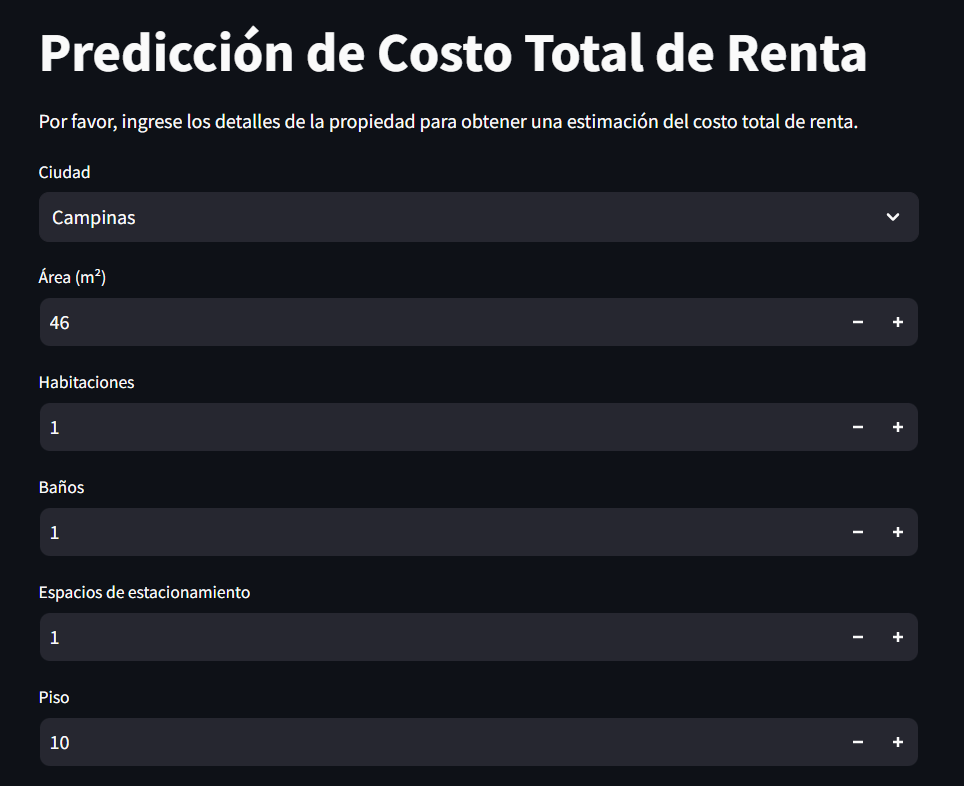
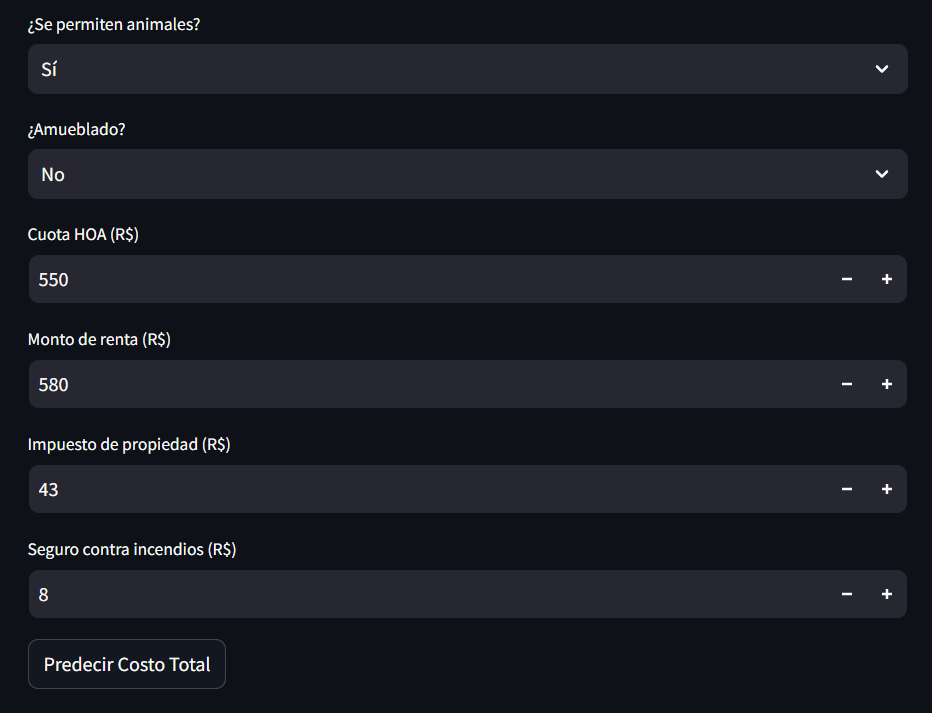
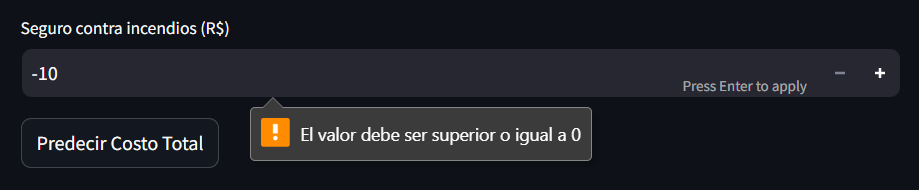

</br>*Realizando una predicción con los valores del siguiente registro del dataset:*</br>
</br>
Ciudad: Campinas </br>
Área: 46</br>
Habitaciones: 1</br>
Baños: 1</br>
Espacios de estacionamiento: 1</br>
Piso: 10</br>
Animales: acept</br>
Amueblado: No</br>
Cuota HOA: 550</br>
Monto de renta: 580</br>
Impuesto de propiedad: 43</br>
Seguro contra incendios: 8</br>
</br>
Costo total (Objetivo): 1181</br>

*Se obtiene:*
</br>

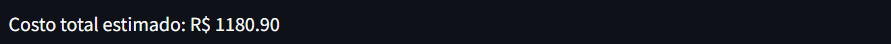

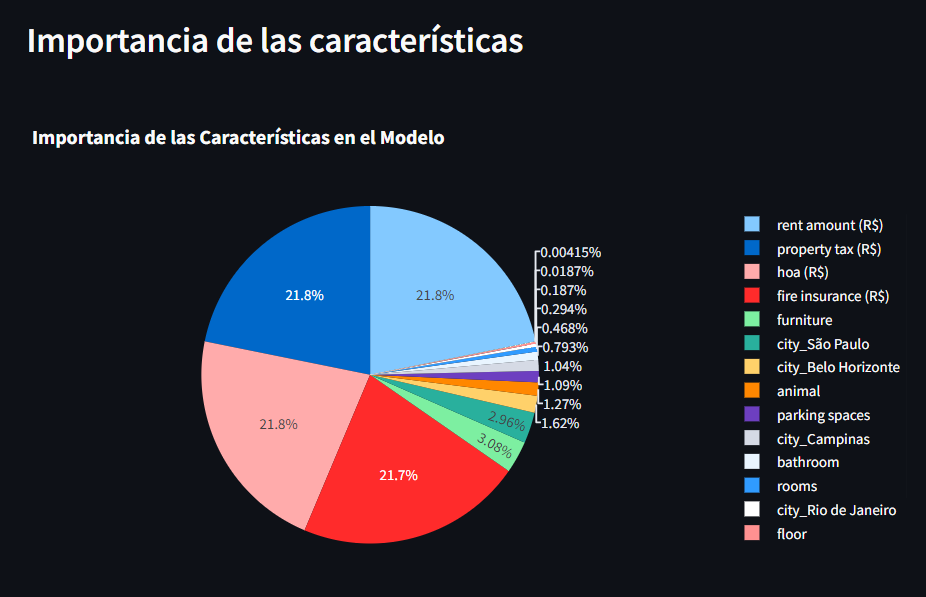
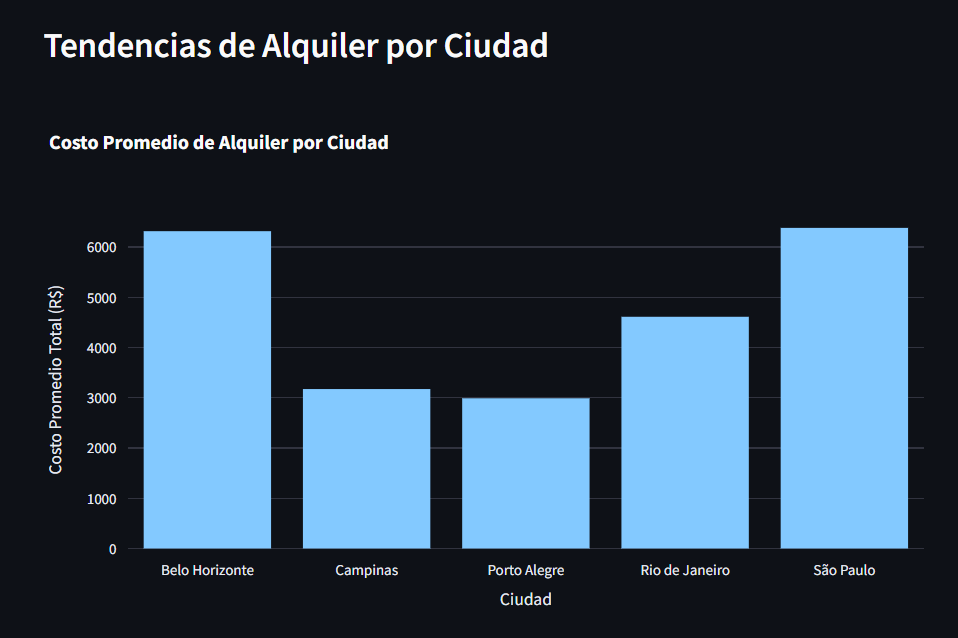

# Parte 3

**Desafíos encontrados durante el proceso de selección del modelo y su puesta en producción**

- **Selección del modelo:** Uno de los principales desafíos fue identificar el modelo de Machine Learning más adecuado para el conjunto de datos. Se tuvo que probar diferentes algoritmos (regresión lineal, árboles de decisión y random forest) para encontrar aquel que mejor capturara las relaciones entre las variables. Además, el modelo seleccionado inicialmente requería ajustes, como la codificación de variables categóricas.

- **Preprocesamiento de datos:** El manejo de datos categóricos (como las ciudades o si una propiedad estaba amueblada) implicó el uso de técnicas de codificación como OneHotEncoder, que añadieron complejidad al preprocesamiento. Fue importante asegurarse de que la codificación no introdujera sesgos en el modelo y que todos los datos estuvieran correctamente transformados antes de ser utilizados, tanto en el entrenamiento del modelo, como en la realización de predicciones desde la interfaz.

- **Puesta en producción:** El despliegue del modelo a través de una interfaz interactiva en *Streamlit* requirió asegurar que todos los elementos del sistema estuvieran bien conectados, incluyendo la carga del modelo y el uso de encoders pre-entrenados. Integrar gráficos interactivos de Plotly también planteó retos en términos de diseño y usabilidad, para garantizar que los usuarios pudieran interpretar fácilmente los resultados.

**Aprendizajes más significativos durante el desarrollo del laboratorio**

- **Importancia del preprocesamiento de datos:** Manejar correctamente los diferentes tipos de datos y aplicar las transformaciones adecuadas fue clave para el desarrollo del laboratorio. El preprocesamiento de características, especialmente el manejo de variables categóricas, fue esencial para mejorar la precisión del modelo.

- **Uso de herramientas de despliegue:** Trabajar con *Streamlit* para crear una interfaz amigable mostró cómo llevar un modelo de Machine Learning más allá de un entorno de desarrollo y hacerlo accesible para usuarios finales. Esta experiencia fue valiosa para aprender sobre la demostración del funcionamiento de los modelos que desarrollemos.

- **Visualización de datos:** Implementar gráficos interactivos ayudó a comprender mejor los patrones en los datos y facilitó la comunicación de resultados. Esto fue especialmente útil para mostrar tendencias de alquiler en diferentes ciudades y destacar la importancia de las características en el modelo.

**Evaluación crítica de las fortalezas y limitaciones del enfoque utilizado**

- **Fortalezas:** La interfaz interactiva creada con *Streamlit* permitió una experiencia de usuario intuitiva y visualmente atractiva, facilitando el acceso a las predicciones de costos de alquiler. Además, el preprocesamiento de datos y la experimentación con diferentes algoritmos ayudó a mejorar el rendimiento del modelo, permitiendo que capturara mejor las relaciones entre las variables de entrada y el costo de alquiler, lo cual es esencial para la demostración del funcionamiento del modelo. Finalmente, La capacidad de visualización interactiva con gráficos de *Plotly* hizo que los resultados fueran más interpretables y claros.

- **Limitaciones:** La selección del modelo y el preprocesamiento utilizado podrían no capturar todas las complejidades del mercado de alquiler. Añadido a esto, la interfaz, aunque funcional, al haberse realizado directamente con una librería de Python,  puede tener limitaciones en términos de rendimiento si se escala para manejar mayores volúmenes de datos o si se amplía para agregar más funcionalidades.

**Sugerencias para mejorar el proceso de desarrollo y despliegue de modelos de Machine Learning en el futuro**

- Probar la puesta en producción con modelos más complejos, como redes neuronales, para así observar qué tan distinto es este proceso comparado con modelos sencillos de regresión o clasificación.

- Intentar realizar múltiples predicciones a la vez, permitiendo que el usuario pueda ingresar estas, mediante un archivo, desde la interfaz.